# Description
---

This notebook can be used to reproduce results form the paper:
"Cross-column DFT-based QSRR model development powered by Machine Learning".

Data (molecular descriptors, column characteristics, and experimental retention times) are loaded, split into training, validation and blind test. QSRR models are built using four ML methods (Ridge Regression, Partial Least Squares, Random Forests and Gradient Boosting). Hyperparameters of the ML QSRR models are optimized using a grid search.

# Requirements
---

1. jupyter
2. notebook
3. numpy
4. pandas
5. matplotlib
6. seaborn
7. scikit-learn
8. shap

# Imports
---

In [1]:
# Install requirements
%pip install numpy==1.22 pandas matplotlib seaborn scikit-learn shap

You should consider upgrading via the '/Users/petar/PycharmProjects/PrincipalComponentAnalysisToolbox/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
from typing import (
    Any,
    Dict,
    List
)

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    PredefinedSplit,
    train_test_split
)

from src.analysis import analyze_model
from src.config import (
    plot_settings,
    split_indices
)
from src.visuals import Visualizer

plt.rcParams.update(plot_settings)

sns.set()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Loading & Processing
---

In [3]:
# Load Data
_data_df: DataFrame = pd.read_csv(
    './data/2023-09-25-qsrr_metlin_dataset.csv'
)

# Drop columns= 'name' and '#', 'ID', "Length"
_data_df.drop(
    columns=['#','name', 'ID', "Length"],
    errors="ignore",
    inplace=True
)

# Display Data
display(_data_df.head())

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,rt
0,12.990628,-0.335181,12.990628,0.035905,0.760602,414.333,389.133,413.127297,148,0,...,0,8,4,0,2,2,3,2.9109,105.3190,687.8
1,12.609649,-3.521975,12.609649,0.030555,0.702317,369.487,342.271,369.172227,140,0,...,2,8,7,0,1,1,2,1.2851,97.7354,590.7
2,11.164259,-0.177407,11.164259,0.137593,0.610213,161.160,154.104,161.047678,60,0,...,2,3,0,0,0,0,2,1.2337,46.2335,583.6
3,11.161791,-0.252097,11.161791,0.221895,0.900805,260.337,240.177,260.152478,102,0,...,1,4,3,0,2,2,3,1.8035,73.0347,579.0
4,11.266054,-0.615607,11.266054,0.048741,0.656633,279.340,258.172,279.158292,110,0,...,4,6,5,0,0,0,2,0.9840,78.1769,603.1


# Data Analysis
---

# Train/Test Split

In [4]:
# X- and y- data
_x: ndarray = _data_df.iloc[:,:-1].values  # Variables -> x1 to x15
_y: ndarray = _data_df.iloc[:,-1].values   # Target: -> tR : retention tiime

# Split initial data into training & blind test sets
_x_train_all, _x_bt, _y_train_all, _y_bt = train_test_split(
    _x,
    _y,
    test_size=0.3
    ,shuffle=True,
    random_state=12345  # For reproducibility
)

# Split the training data further into training and validation
_x_train, _x_validation, _y_train, _y_validation = train_test_split(
    _x_train_all,
    _y_train_all,
    test_size=0.3,
    random_state=12345   # For reproducibility
)

# Summary
print('X-train:', _x_train.shape)
print('y-train:', _y_train.shape)
print('- - '*10)
print('X-validation:', _x_validation.shape)
print('y-validation:', _y_validation.shape)
print('- - '*10)
print('X-BT:', _x_bt.shape)
print('y-BT:', _y_bt.shape)
print('- - '*10)

# Using Predefiend Set of data for validation for hyper-parameter optimization
ps = PredefinedSplit(test_fold=split_indices)

X-train: (38171, 123)
y-train: (38171,)
- - - - - - - - - - - - - - - - - - - - 
X-validation: (16359, 123)
y-validation: (16359,)
- - - - - - - - - - - - - - - - - - - - 
X-BT: (23371, 123)
y-BT: (23371,)
- - - - - - - - - - - - - - - - - - - - 


# Hyper-Parameter Optimization, QSRR model building & analysis
---

## Random Forests
---

In [5]:
# RFs parameter grid
_rfs_param_grid: Dict[str, Any] = {
    'n_estimators': range(10, 210, 10),
    'max_features': [None, 'sqrt'],
    'max_depth': range(2, 30, 3),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
}

In [6]:
# Instantiate model
_rfs_model: GridSearchCV = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=_rfs_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=20,
    verbose=10,
    refit=True
)

In [7]:
# Fit model
_rfs_model.fit(
    deepcopy(_x_train_all),  # Use all, because we extracted the validation indices previously for reproducibility
    deepcopy(_y_train_all)   # Use all, because we extracted the validation indices previously for reproducibility
)

Fitting 1 folds for each of 7200 candidates, totalling 7200 fits
[CV 1/1; 1/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/1; 1/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=-110.950 total time=   0.1s
[CV 1/1; 22/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=20
[CV 1/1; 22/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=20;, score=-115.460 total time=   0.1s
[CV 1/1; 25/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/1; 25/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-116.438 total time=   0.4s
[CV 1/1; 33/7200] START bootstrap=True, max_depth=2, max_feat

[CV 1/1; 12/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/1; 12/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=-115.969 total time=   0.9s
[CV 1/1; 44/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40
[CV 1/1; 44/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40;, score=-115.609 total time=   0.3s
[CV 1/1; 52/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 1/1; 52/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=-115.969 total time=   0.9s
[CV 1/1; 71/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_e

[CV 1/1; 4/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 1/1; 4/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=-115.609 total time=   0.3s
[CV 1/1; 27/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 27/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-116.453 total time=   0.6s
[CV 1/1; 37/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=170
[CV 1/1; 37/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=170;, score=-116.093 total time=   1.2s
[CV 1/1; 64/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimator

[CV 1/1; 521/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=10;, score=-117.369 total time=   0.1s
[CV 1/1; 523/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=30
[CV 1/1; 523/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=30;, score=-115.469 total time=   0.3s
[CV 1/1; 530/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100
[CV 1/1; 530/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=-113.300 total time=   1.2s
[CV 1/1; 549/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=90
[CV 1/1; 549/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2,

[CV 1/1; 10/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/1; 10/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-116.103 total time=   0.8s
[CV 1/1; 39/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=190
[CV 1/1; 39/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=190;, score=-116.269 total time=   1.4s
[CV 1/1; 70/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 70/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=-116.091 total time=   0.7s
[CV 1/1; 89/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_est

[CV 1/1; 679/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-120.573 total time=   0.9s
[CV 1/1; 716/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 716/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-120.516 total time=   0.7s
[CV 1/1; 738/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180
[CV 1/1; 738/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180;, score=-111.331 total time=   3.1s
[CV 1/1; 775/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 775/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=

[CV 1/1; 20/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/1; 20/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-116.336 total time=   1.5s
[CV 1/1; 82/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20
[CV 1/1; 82/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20;, score=-115.460 total time=   0.1s
[CV 1/1; 85/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=50
[CV 1/1; 85/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=50;, score=-116.438 total time=   0.3s
[CV 1/1; 94/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimat

[CV 1/1; 692/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 692/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-120.184 total time=   0.5s
[CV 1/1; 714/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 714/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-119.777 total time=   0.6s
[CV 1/1; 736/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 736/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-111.155 total time=   2.8s
[CV 1/1; 770/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split

[CV 1/1; 135/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=-115.492 total time=   1.1s
[CV 1/1; 162/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=20
[CV 1/1; 162/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=20;, score=-116.877 total time=   0.1s
[CV 1/1; 165/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50
[CV 1/1; 165/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=-116.968 total time=   0.4s
[CV 1/1; 175/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=150
[CV 1/1; 175/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10

[CV 1/1; 1005/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 1005/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-121.360 total time=   0.2s
[CV 1/1; 1015/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 1015/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-118.253 total time=   0.6s
[CV 1/1; 1041/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10
[CV 1/1; 1041/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=-126.090 total time=   0.0s
[CV 1/1; 1044/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_

[CV 1/1; 643/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30;, score=-123.728 total time=   0.1s
[CV 1/1; 649/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 649/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=90;, score=-119.506 total time=   0.4s
[CV 1/1; 670/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 670/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-121.440 total time=   0.4s
[CV 1/1; 686/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=60
[CV 1/1; 686/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n

[CV 1/1; 481/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=-117.369 total time=   0.1s
[CV 1/1; 483/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=30
[CV 1/1; 483/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=30;, score=-115.469 total time=   0.3s
[CV 1/1; 490/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100
[CV 1/1; 490/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-113.300 total time=   1.2s
[CV 1/1; 507/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70
[CV 1/1; 507/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_es

[CV 1/1; 1094/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=140
[CV 1/1; 1094/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=140;, score=-111.467 total time=   2.7s
[CV 1/1; 1124/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40
[CV 1/1; 1124/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40;, score=-115.426 total time=   0.5s
[CV 1/1; 1131/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=110
[CV 1/1; 1131/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=110;, score=-113.659 total time=   1.5s
[CV 1/1; 1150/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min

[CV 1/1; 498/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=180;, score=-111.922 total time=   2.2s
[CV 1/1; 531/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=110
[CV 1/1; 531/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=110;, score=-112.632 total time=   1.4s
[CV 1/1; 555/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/1; 555/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-117.461 total time=   0.7s
[CV 1/1; 576/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=160
[CV 1/1; 576/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5

[CV 1/1; 78/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 78/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-116.262 total time=   1.3s
[CV 1/1; 113/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 113/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=130;, score=-115.972 total time=   1.0s
[CV 1/1; 137/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170
[CV 1/1; 137/7200] END bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170;, score=-115.990 total time=   1.2s
[CV 1/1; 169/7200] START bootstrap=True, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=1

[CV 1/1; 382/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=20;, score=-117.196 total time=   0.3s
[CV 1/1; 387/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 387/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-114.827 total time=   0.8s
[CV 1/1; 397/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=1; 689/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=90;, score=-120.312 total time=   0.4s
[CV 1/1; 702/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=20
[CV 1/1; 702/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=20;, score=-122.589 total time=   0.1

[CV 1/1; 953/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130;, score=-118.066 total time=   0.5s
[CV 1/1; 972/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 972/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-118.007 total time=   0.6s
[CV 1/1; 996/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5ue, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=130;, score=-126.730 total time=   0.5s
[CV 1/1; 280/7200] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200
[CV 1/1; 280/7200] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=-128.204 total time=   0.8s


[CV 1/1; 512/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 512/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-112.681 total time=   1.5s
[CV 1/1; 534/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 534/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-111.592 total time=   1.8s
[CV 1/1; 570/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1; 570/7200] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-120.193 total time=   0.5s
[CV 1/1; 588/7200] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split

ples_split=5, n_estimators=30;, score=-114.086 total time=   0.4s
[CV 1/1; 449/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=90
[CV 1/1; 449/7200] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=90;, score=-113.901 total time=   1.1s
[CV 1/1; 467/7200] START bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 467/7200] END bootstrap=True, max_deit=5, n_estimators=10;, score=-116.043 total time=   0.0s
[CV 1/1; 984/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=40
[CV 1/1; 984/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=40;, score=-119.940 total time=   0.2s
[CV 1/1; 992/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5

[CV 1/1; 1116/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=160
[CV 1/1; 1116/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=160;, score=-111.978 total time=   2.6s
[CV 1/1; 1146/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=60
[CV 1/1; 1146/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=60;, score=-116.035 total time=   0.8s
[CV 1/1; 1156/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 1156/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-111.545 total time=   2.2s
[CV 1/1; 1186/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_sam

[CV 1/1; 735/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-111.145 total time=   2.7s
[CV 1/1; 767/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70
[CV 1/1; 767/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-115.736 total time=   1.0s
[CV 1/1; 780/7200] START bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/1; 780/7200] END bootstrap=True, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_splples_split=2, n_estimators=130
[CV 1/1; 1093/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130;, score=-111.994 total time=   2.5s
[CV 1/1; 1122/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=1, min_samp

[CV 1/1; 1157/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=170;, score=-111.671 total time=   2.3s
[CV 1/1; 1188/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80
[CV 1/1; 1188/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80;, score=-114.985 total time=   1.0s
[CV 1/1; 1203/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=30
[CV 1/1; 1203/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=30;, score=-115.494 total time=   0.4s
[CV 1/1; 1209/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=90
[CV 1/1; 1209/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_sample

[CV 1/1; 1285/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-123.073 total time=   0.2s
[CV 1/1; 1291/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=110
[CV 1/1; 1291/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=-118.517 total time=   0.7s
[CV 1/1; 1309/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 1309/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90;, score=-119.649 total time=   0.4s
[CV 1/1; 1324/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 1324/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_sampl

[CV 1/1; 1172/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-112.108 total time=   1.7s
[CV 1/1; 1195/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 1195/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-111.836 total time=   1.9s
[CV 1/1; 1224/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimatoestimators=10
[CV 1/1; 1001/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=-123.040 total time=   0.1s
[CV 1/1; 1004/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=40
[CV 1/1; 1004/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, m

[CV 1/1; 974/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=140;, score=-118.255 total time=   0.7s
[CV 1/1; 1000/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200
[CV 1/1; 1000/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=-119.067 total time=   0.9s
[CV 1/1; 1039/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190
[CV 1/1; 1039/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-120.369 total time=   0.9s
[CV 1/1; 1077/7200] START bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 1077/7200] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_sp

[CV 1/1; 1158/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-111.583 total time=   2.5s
[CV 1/1; 1192/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=120
[CV 1/1; 1192/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=120;, score=-112.831 total time=   1.5s
[CV 1/1; 1214/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=5, mplit=10, n_estimators=180;, score=-112.013 total time=   2.5s
[CV 1/1; 1171/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110
[CV 1/1; 1171/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110;, score=-112.776 total time=   1.6s
[CV 1/1; 1193/7200] START bootstrap=True, max_depth=11, max_features=None

[CV 1/1; 1306/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60;, score=-121.150 total time=   0.3s
[CV 1/1; 1317/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=170
[CV 1/1; 1317/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=170;, score=-120.174 total time=   0.8s
[CV 1/1; 1349/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimatorseaf=3, min_samples_split=5, n_estimators=30;, score=-114.159 total time=   0.4s
[CV 1/1; 1528/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=80
[CV 1/1; 1528/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=80;, score=-114.171 total time=   1.2s
[CV 1/1; 1544/7200] START

[CV 1/1; 1595/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=150;, score=-111.474 total time=   1.8s
[CV 1/1; 1623/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30
[CV 1/1; 1623/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=-117.666 total time=   0.2s
[CV 1/1; 1627/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70
[CV 1/1; 1627/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70;, score=-117.027 total time=   0.4s
[CV 1/1; 1634/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=140
[CV 1/1; 1634/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples

[CV 1/1; 1516/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-111.516 total time=   2.3s
[CV 1/1; 1545/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 1545/7200] END bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-115.794 total time=   0.7s
[CV 1/1; 1556/7200] START bootstrap=True, max_depth=14, max_features=None, min_samples_leaf=3, min_samples_split=10, s=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-118.487 total time=   1.0s
[CV 1/1; 1337/7200] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=170
[CV 1/1; 1337/7200] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=170;, score=-118.784 total time=   0.8s
[CV 1/1; 1366/

[CV 1/1; 1834/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=140
[CV 1/1; 1834/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=140;, score=-110.913 total time=   1.1s
[CV 1/1; 1848/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 1/1; 1848/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=-115.718 total time=   0.5s
[CV 1/1; 185, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 1692/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-117.993 total time=   0.5s
[CV 1/1; 1711/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators

[CV 1/1; 1905/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 1905/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-115.794 total time=   0.3s
[CV 1/1; 1910/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 1/1; 1910/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=-114.132 total time=   0.6s
[CV 1/1; 1919/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=190
[CV 1/1; 1919/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=190;, score=-111.827 total time=   1.3s
[CV 1/1; 1938/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, m

[CV 1/1; 1734/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=140;, score=-118.431 total time=   0.4s
[CV 1/1; 1751/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=110
[CV 1/1; 1751/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=110;, score=-120.584 total time=   0.3s
[CV 1/1; 1767/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=70
[CV 1/1; 1767/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=70;, score=-120.969 total time=   0.2s
[CV 1/1; 1775/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=150
[CV 1/1; 1775/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samp

[CV 1/1; 2197/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=170;, score=-111.710 total time=   1.3s
[CV 1/1; 2212/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 1/1; 2212/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=-113.166 total time=   0.7s
[CV 1/1; 2221/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=10
[CV 1/1; 2221/7200] END bootstrap=True, max_depth=20, max_featuressplit=10, n_estimators=60;, score=-122.665 total time=   0.2s
[CV 1/1; 1793/7200] START bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=130
[CV 1/1; 1793/7200] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=130;, sco

[CV 1/1; 1161/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10
[CV 1/1; 1161/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-118.463 total time=   0.1s
[CV 1/1; 1162/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20
[CV 1/1; 1162/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20;, score=-116.074 total time=   0.3s
[CV 1/1; 1166/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 1166/7200] END bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-116.035 total time=   0.9s
[CV 1/1; 1178/7200] START bootstrap=True, max_depth=11, max_features=None, min_samples_leaf=3, min_samples

[CV 1/1; 2715/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/1; 2715/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-120.536 total time=   0.4s
[CV 1/1; 2723/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30
[CV 1/1; 2723/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=30;, score=-121.273 total time=   0.1s
[CV 1/1; 2727/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 2727/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-120.878 total time=   0.2s
[CV 1/1; 2735/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 1/1; 1879/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=190
[CV 1/1; 1879/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=190;, score=-111.360 total time=   1.3s
[CV 1/1; 1898/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180
[CV 1/1; 1898/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180;, score=-111.558 total time=   1.3s
[CV 1/1; 1915/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 1915/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-111.836 total time=   1.0s
[CV 1/1; 1929/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=5, min

[CV 1/1; 2763/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30
[CV 1/1; 2763/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30;, score=-120.572 total time=   0.1s
[CV 1/1; 2766/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=60
[CV 1/1; 2766/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=60;, score=-120.084 total time=   0.1s
[CV 1/1; 2773/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=130
[CV 1/1; 2773/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=130;, score=-117.986 total time=   0.3s
[CV 1/1; 2785/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_sampl

[CV 1/1; 2091/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-118.729 total time=   0.2s
[CV 1/1; 2100/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 2100/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=-118.256 total time=   0.4s
[CV 1/1; 2119/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190
[CV 1/1; 2119/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-120.236 total time=   0.4s
[CV 1/1; 2137/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=170
[CV 1/1; 2137/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_

[CV 1/1; 2357/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=170
[CV 1/1; 2357/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=170;, score=-120.949 total time=   0.5s
[CV 1/1; 2374/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=140
[CV 1/1; 2374/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=140;, score=-117.911 total time=   0.4s
[CV 1/1; 2391/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=110
[CV 1/1; 2391/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=110;, score=-118.908 total time=   0.3s
[CV 1/1; 2403/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min

[CV 1/1; 2966/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 2966/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-115.973 total time=   0.5s
[CV 1/1; 2972/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120
[CV 1/1; 2972/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-112.076 total time=   1.1s
[CV 1/1; 2985/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/1; 2985/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=-115.794 total time=   0.3s
[CV 1/1; 2990/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_sam

[CV 1/1; 2965/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=50
[CV 1/1; 2965/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=50;, score=-115.527 total time=   0.4s
[CV 1/1; 2971/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110
[CV 1/1; 2971/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=110;, score=-112.740 total time=   1.1s
[CV 1/1; 2982/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=20
[CV 1/1; 2982/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=20;, score=-115.998 total time=   0.1s
[CV 1/1; 2984/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=3, min_sam

[CV 1/1; 2086/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=60
[CV 1/1; 2086/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=60;, score=-120.987 total time=   0.1s
[CV 1/1; 2093/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 2093/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130;, score=-117.877 total time=   0.3s
[CV 1/1; 2103/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30
[CV 1/1; 2103/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30;, score=-123.095 total time=   0.1s
[CV 1/1; 2106/7200] START bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_s

[CV 1/1; 3143/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=30
[CV 1/1; 3143/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=30;, score=-120.572 total time=   0.2s
[CV 1/1; 3149/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=90
[CV 1/1; 3149/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=90;, score=-118.523 total time=   0.5s
[CV 1/1; 1872/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 1872/7200] END bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120;, score=-112.076 total time=   0.9s
[CV 1/1; 1883/7200] START bootstrap=True, max_depth=17, max_features=None, min_samples_leaf=3, min_sampl

[CV 1/1; 2867/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=70;, score=-120.969 total time=   0.2s
[CV 1/1; 2875/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150
[CV 1/1; 2875/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=150;, score=-119.830 total time=   0.4s
[CV 1/1; 2886/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=60
[CV 1/1; 2886/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=60;, score=-116.075 total time=   0.7s
[CV 1/1; 2897/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=170
[CV 1/1; 2897/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=1, min_sam

[CV 1/1; 2159/7200] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=190;, score=-120.236 total time=   0.4s
[CV 1/1; 2172/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/1; 2172/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=-112.536 total time=   1.3s
[CV 1/1; 2185/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50
[CV 1/1; 2185/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-113.151 total time=   0.5s
[CV 1/1; 2190/7200] START bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1; 2190/7200] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=1, min_samp

[CV 1/1; 2480/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=-119.905 total time=   0.5s
[CV 1/1; 2500/7200] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=200
[CV 1/1; 2500/7200] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=-119.905 total time=   0.6s
[CV 1/1; 2521/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/1; 2521/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_sam[CV 1/1; 2582/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=20;, score=-116.070 total time=   0.1s
[CV 1/1; 2585/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV

[CV 1/1; 2536/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 2536/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-111.410 total time=   1.8s
[CV 1/1; 2554/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=140
[CV 1/1; 2554/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=140;, score=-110.913 total time=   1.3s
[CV 1/1; 2570/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 1/1; 2570/7200] END bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-114.604 total time=   0.8s
[CV 1/1; 2579/7200] START bootstrap=True, max_depth=23, max_features=None, min_samples_leaf=1, min

[CV 1/1; 2775/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=-117.874 total time=   0.4s
[CV 1/1; 2788/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=80
[CV 1/1; 2788/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=80;, score=-119.540 total time=   0.2s
[CV 1/1; 2798/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=180
[CV 1/1; 2798/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=180;, score=-118.912 total time=   0.4s
[CV 1/1; 2813/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 2813/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samp

[CV 1/1; 3296/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=160
[CV 1/1; 3296/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=160;, score=-112.024 total time=   2.2s
[CV 1/1; 3324/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=40
[CV 1/1; 3324/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=40;, score=-114.130 total time=   0.6s
[CV 1/1; 333True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150
[CV 1/1; 3515/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-117.874 total time=   0.8s
[CV 1/1; 3545/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estima

[CV 1/1; 3087/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 3087/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-120.878 total time=   0.5s
[CV 1/1; 3099/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=190
[CV 1/1; 3099/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=190;, score=-118.111 total time=   1.1s
[CV 1/1; 3136/7200] START bootstra[CV 1/1; 2737/7200] START bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170
[CV 1/1; 2737/7200] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170;, score=-118.036 total time=   0.4s
[CV 1/1; 2750/7200] START bootstrap=True, max_depth=23, max_features

[CV 1/1; 3440/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-120.420 total time=   1.1s
[CV 1/1; 3473/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130
[CV 1/1; 3473/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130;, score=-118.252 total time=   0.6s
[CV 1/1; 3497/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=170
[CV 1/1; 3497/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=170;, score=-118.936 total time=   0.9s
[CV 1/1; 3533/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=130
[CV 1/1; 3533/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=3, min_

[CV 1/1; 3010/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-113.214 total time=   0.7s
[CV 1/1; 3019/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190
[CV 1/1; 3019/7200] END bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-111.291 total time=   1.3s
[CV 1/1; 3039/7200] START bootstrap=True, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-111.557 total time=   2.0s
[CV 1/1; 3457/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170
[CV 1/1; 3457/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170;, score=-118.036 total time=   0.8s
[CV 1/1; 3486/7200] START bootstrap=True, m

[CV 1/1; 3275/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150;, score=-111.356 total time=   2.4s
[CV 1/1; 3301/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=10
[CV 1/1; 3301/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=10;, score=-118.438 total time=   0.1s
[CV 1/1; 3304/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 3304/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-114.130 total time=   0.6s
[CV 1/1; 3312/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=120
[CV 1/1; 3312/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples

[CV 1/1; 3678/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180
[CV 1/1; 3678/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-135.896 total time=   1.6s
[CV 1/1; 3711/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=110
[CV 1/1; 3711/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-135.896 total time=   1.0s
[CV 1/1; 3732/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 1/1; 3732/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=-135.896 total time=   1.1s
[CV 1/1; 3754/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min

[CV 1/1; 3311/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 3311/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-112.740 total time=   1.6s
[CV 1/1; 3333/7200] START bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 3333/7200] END bootstrap=True, max_depth=29, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130;, score=-111.696 total time=   1.8s
[CV 1/1; 3358/7200] START bootstrap=True, max_depth=29, max_feattors=60
[CV 1/1; 3146/7200] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-120.084 total time=   0.4s
[CV 1/1; 3159/7200] START bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=190
[CV 1/1; 3159/7200] END boots

[CV 1/1; 4022/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=20;, score=-140.655 total time=   0.3s
[CV 1/1; 4026/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=60
[CV 1/1; 4026/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=60;, score=-140.727 total time=   0.9s
[CV 1/1; 4036/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 4036/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-140.865 total time=   2.5s
[CV 1/1; 4063/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=30
[CV 1/1; 4063/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_sample

[CV 1/1; 4001/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10
[CV 1/1; 4001/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-138.279 total time=   0.2s
[CV 1/1; 4002/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=20
[CV 1/1; 4002/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=20;, score=-137.892 total time=   0.3s
[CV 1/1; 4006/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=60
[CV 1/1; 4006/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=60;, score=-137.910 total time=   0.9s
[CV 1/1; 4017/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_s

[CV 1/1; 3616/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 3616/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-135.896 total time=   1.5s
[CV 1/1; 3647/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70
[CV 1/1; 3647/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-135.896 total time=   0.6s
[CV 1/1; 3660/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/1; 3660/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-135.896 total time=   1.9s
[CV 1/1; 3697/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min

[CV 1/1; 3596/7200] START bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 3596/7200] END bootstrap=True, max_depth=29, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-120.130 total time=   0.7s
[CV 1/1; 3620/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/1; 3620/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-135.896 total time=  _split=2, n_estimators=200
[CV 1/1; 3800/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-127.862 total time=   0.6s
[CV 1/1; 3827/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70
[CV 1/1; 3827/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_

[CV 1/1; 3636/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=160
[CV 1/1; 3636/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=160;, score=-135.896 total time=   1.5s
[CV 1/1; 3665/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/1; 3665/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=-135.896 total time=   0.5s
[CV 1/1; 3676/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 3676/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-135.896 total time=   1.5s
[CV 1/1; 3706/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_sam

[CV 1/1; 4188/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=-118.595 total time=   0.2s
[CV 1/1; 4195/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/1; 4195/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=-117.166 total time=   0.3s
[CV 1/1; 4211/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 4211/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-116.111 total time=   0.2s
[CV 1/1; 4221/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=10
[CV 1/1; 4221/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_sa

[CV 1/1; 4449/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=90
[CV 1/1; 4449/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=90;, score=-135.926 total time=   1.1s
[CV 1/1; 4459/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190
[CV 1/1; 4459/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=190;, score=-135.733 total time=   2.3s
[CV 1/1; 4484/7200] START bootstrap=False, max_depth=8plit=5, n_estimators=40
[CV 1/1; 4344/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=40;, score=-140.229 total time=   0.5s
[CV 1/1; 4348/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 1/1; 4348/7200] END bo

[CV 1/1; 4103/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30
[CV 1/1; 4103/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=30;, score=-129.277 total time=   0.4s
[CV 1/1; 4107/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70
[CV 1/1; 4107/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70;, score=-129.464 total time=   1.0s
[CV 1/1; 4119/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=190
[CV 1/1; 4119/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=190;, score=-129.362 total time=   2.6s
[CV 1/1; 4154/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 1/1; 4415/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=150
[CV 1/1; 4415/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-146.760 total time=   2.2s
[CV 1/1; 4435/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 4435/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-138.188 total time=   2.0s
[CV 1/1; 4454/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=140
[CV 1/1; 4454/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=140;, score=-135.865 total time=   1.7s
[CV 1/1; 4473/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min

[CV 1/1; 4155/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 1/1; 4155/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-115.083 total time=   0.4s
[CV 1/1; 4167/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 4167/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-118.870 total time=   0.3s
[CV 1/1; 4176/7200] START bootstrap=plit=10, n_estimators=170
[CV 1/1; 4497/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=170;, score=-135.791 total time=   2.1s
[CV 1/1; 4539/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=190
[CV 1/1; 4539/7200] END bootstrap=False

[CV 1/1; 3651/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=110;, score=-135.896 total time=   1.1s
[CV 1/1; 3673/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=130
[CV 1/1; 3673/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=130;, score=-135.896 total time=   1.3s
[CV 1/1; 3699/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=3, min[CV 1/1; 4066/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=60
[CV 1/1; 4066/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=60;, score=-137.915 total time=   0.9s
[CV 1/1; 4077/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170


[CV 1/1; 4412/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-146.812 total time=   1.8s
[CV 1/1; 4429/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 4429/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90;, score=-138.248 total time=   1.2s
[CV 1/1; 4440/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 1/1; 4440/7200] END bootstrap=False, max_depth=8, max_features=None, mV 1/1; 4380/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200
[CV 1/1; 4380/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-137.044 total time=   2.7s
[CV 1/1; 4408/7200] START

[CV 1/1; 4371/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=110
[CV 1/1; 4371/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=110;, score=-136.911 total time=   1.3s
[CV 1/1; 4383/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=30
[CV 1/1; 4383/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samplamples_split=5, n_estimators=110
[CV 1/1; 4111/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=110;, score=-129.416 total time=   1.5s
[CV 1/1; 4129/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=90
[CV 1/1; 4129/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=90;

[CV 1/1; 4226/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-118.312 total time=   0.1s
[CV 1/1; 4232/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=120
[CV 1/1; 4232/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-116.156 total time=   0.3s
[CV 1/1; 4244/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=40
[CV 1/1; 4244/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=40;, score=-123.507 total time=   0.1s
[CV 1/1; 4247/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=70
[CV 1/1; 4247/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samp

[CV 1/1; 3785/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=-126.955 total time=   0.1s
[CV 1/1; 3790/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/1; 3790/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-127.024 total time=   0.3s
[CV 1/1; 3799/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=190
[CV 1/1; 3799/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=190;, score=-127.636 total time=   0.6s
[CV 1/1; 3825/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 1/1; 3825/7200] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samp

[CV 1/1; 4571/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110
[CV 1/1; 4571/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=110;, score=-115.970 total time=   0.3s
[CV 1/1; 4586/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 4586/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples; 4419/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=190;, score=-146.732 total time=   2.7s
[CV 1/1; 4446/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=60
[CV 1/1; 4446/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=60;, score=-135.746 total time=   0.8s
[CV 1/

[CV 1/1; 4590/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100
[CV 1/1; 4590/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=-116.404 total time=   0.3s
[CV 1/1; 4603/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30
[CV 1/1; 4603/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=30;, score=-116.478 total time=   0.1s
[CV 1/1; 4608/7200] START bootst617/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=170
[CV 1/1; 4617/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=170;, score=-113.544 total time=   0.5s
[CV 1/1; 4637/7200] START bootstrap=False, max_depth=8, max_features=sqrt, m

[CV 1/1; 4401/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-147.115 total time=   0.2s
[CV 1/1; 4403/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=30
[CV 1/1; 4403/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=30;, score=-147.473 total time=   0.4s
[CV 1/1; 4409/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=90
[CV 1/1; 4409/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=90;, score=-147.000 total time=   1.3s
[CV 1/1; 4420/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=200
[CV 1/1; 4420/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_

[CV 1/1; 4379/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190
[CV 1/1; 4379/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190;, score=-137.056 total time=   2.6s
[CV 1/1; 4404/7200] START bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=40
[CV 1/1; 4404/7200] END bootstrap=False, max_depth=8, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=40;, score=-147.308 total time=  samples_split=2, n_estimators=200;, score=-115.688 total time=   0.6s
[CV 1/1; 4667/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=70
[CV 1/1; 4667/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=70;, score=-116.286 total time=   0.2s
[CV 1/1; 4676/7200] START bootstrap=

[CV 1/1; 4140/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=-129.370 total time=   2.4s
[CV 1/1; 4209/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90
[CV 1/1; 4209/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=90;, score=-116.863 total time=   0.2s
[CV 1/1; 4219/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=190
[CV 1/1; 4219/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_sample[CV 1/1; 4069/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90
[CV 1/1; 4069/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=90;, score=-137.720 total time=   1.4

[CV 1/1; 3727/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=70
[CV 1/1; 3727/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=70;, score=-135.896 total time=   0.6s
[CV 1/1; 3740/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200
[CV 1/1; 3740/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=200;, score=-135.896 total time=   1.8s
[CV 1/1; 3777/7200] START bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 3777/7200] END bootstrap=False, max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=170;, score=-135.896 total time=   1.6s
[CV 1/1; 3829/7200] START bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_s

[CV 1/1; 4711/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=-139.782 total time=   1.7s
[CV 1/1; 4724/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40
[CV 1/1; 4724/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40;, score=-136.497 total time=   0.5s
[CV 1/1; 4730/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 1/1; 4730/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-136.898 total time=   1.5s
[CV 1/1; 4741/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=10
[CV 1/1; 4741/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3,

[CV 1/1; 5002/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=20;, score=-119.873 total time=   0.1s
[CV 1/1; 5005/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50
[CV 1/1; 5005/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=-119.110 total time=   0.1s
[CV 1/1; 5010/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100
[CV 1/1; 5010/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=-116.521 total time=   0.2s
[CV 1/1; 5019/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=190
[CV 1/1; 5019/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min

[CV 1/1; 4282/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=20;, score=-123.513 total time=   0.0s
[CV 1/1; 4285/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50
[CV 1/1; 4285/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=-122.213 total time=   0.1s
[CV 1/1; 4291/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=110
[CV 1/1; 4291/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=110;, score=-119.824 total time=   0.2s
[CV 1/1; 4301/7200] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10
[CV 1/1; 4301/7200] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_sample

[CV 1/1; 4754/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=140;, score=-145.474 total time=   2.0s
[CV 1/1; 4773/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130
[CV 1/1; 4773/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=130;, score=-145.470 total time=   1.9s
[CV 1/1; 4791/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=110
[CV 1/1; 4791/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-137.997 total time=   1.5s
[CV 1/1; 4804/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=40
[CV 1/1; 4804/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5,

[CV 1/1; 4058/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=180;, score=-140.926 total time=   2.7s
[CV 1/1; 4087/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=70
[CV 1/1; 4087/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=70;, score=-129.464 total time=   1.0s
[CV 1/1; 4097/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170
[CV 1/1; 4097/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=170;, score=-129.366 total time=   2.3s
[CV 1/1; 4124/7200] START bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=40
[CV 1/1; 4124/7200] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=5, min_sampl

[CV 1/1; 5200/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=200;, score=-135.676 total time=   1.9s
[CV 1/1; 5220/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200
[CV 1/1; 5220/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=-135.676 total time=   2.1s
[CV 1/1; 5263/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30
[CV 1/1; 5263/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30;, score=-112.450 total time=   0.1s
[CV 1/1; 5268/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 1/1; 5268/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1

[CV 1/1; 5247/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 5247/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70;, score=-116.672 total time=   0.2s
[CV 1/1; 5254/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=140
[CV 1/1; 5254/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=140;, score=-114.690 total time=   0.4s
[CV 1/1; 5267/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70
[CV 1/1; 5267/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=70;, score=-113.515 total time=   0.2s
[CV 1/1; 5276/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, 

[CV 1/1; 4520/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-117.755 total time=   0.6s
[CV 1/1; 4537/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170
[CV 1/1; 4537/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=170;, score=-113.979 total time=   0.4s
[CV 1/1; 5052/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 1/1; 5052/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=-139.156 total time=   2.1s
[CV 1/1; 5066/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60
[CV 1/1; 5066/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_

[CV 1/1; 4657/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=170;, score=-115.510 total time=   0.4s
[CV 1/1; 4677/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 4677/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=170;, score=-115.510 total time=   0.4s
[CV 1/1; 4691/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=110
[CV 1/1; 4691/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=110;, score=-139.043 total time=   2.0s
[CV 1/1; 4707/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70
[CV 1/1; 4707/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, mi

[CV 1/1; 4761/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=10;, score=-144.270 total time=   0.1s
[CV 1/1; 4763/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=30
[CV 1/1; 4763/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=30;, score=-146.462 total time=   0.4s
[CV 1/1; 4768/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 1/1; 5330/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=-116.693 total time=   0.2s
n_samples_split=2, n_estimators=200
[CV 1/1; 5300/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=-116.183 total time=   0.5s
[

[CV 1/1; 4795/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 1/1; 4795/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=-137.998 total time=   2.1s
[CV 1/1; 4814/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=140
[CV 1/1; 4814/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=140;, score=-135.865 total time=   1.7s
[CV 1/1; 4832/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120
[CV 1/1; 4832/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=120;, score=-135.920 total time=   1.5s
[CV 1/1; 4849/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf

[CV 1/1; 4838/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=180
[CV 1/1; 4838/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=180;, score=-135.779 total time=   2.2s
[CV 1/1; 4861/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/1; 4861/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=-125.504 total time=   0.0s
[CV 1/1; 4862/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20
[CV 1/1; 4862/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=-122.241 total time=   0.1s
[CV 1/1; 4864/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, mi

[CV 1/1; 5187/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=70;, score=-135.818 total time=   0.7s
[CV 1/1; 5194/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=140
[CV 1/1; 5194/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=140;, score=-135.865 total time=   1.4s
[CV 1/1; 5209/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=90
[CV 1/1; 5209/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=90;, score=-135.926 total time=   0.9s
[CV 1/1; 5217/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=170
[CV 1/1; 5217/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, 

[CV 1/1; 5407/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=70;, score=-139.211 total time=   1.3s
[CV 1/1; 5419/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=190
[CV 1/1; 5419/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=190;, score=-138.925 total time=   3.6s
[CV 1/1; 5444/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40
[CV 1/1; 5444/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40;, score=-136.497 total time=   0.5s
[CV 1/1; 5449/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=90
[CV 1/1; 5449/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, m

[CV 1/1; 5433/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130;, score=-139.257 total time=   2.0s
[CV 1/1; 5448/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 1/1; 5448/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=-136.966 total time=   1.1s
[CV 1/1; 5457/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=170
[CV 1/1; 5457/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=170;, score=-136.908 total time=   2.3s
[CV 1/1; 5477/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=170
[CV 1/1; 5477/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3

[CV 1/1; 4564/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40
[CV 1/1; 4564/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=40;, score=-119.957 total time=   0.1s
[CV 1/1; 4570/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 1/1; 4570/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=-116.404 total time=   0.3[CV 1/1; 5047/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=70
[CV 1/1; 5047/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=70;, score=-139.600 total time=   1.2s
[CV 1/1; 5059/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=1, min_samp

[CV 1/1; 4942/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=20
[CV 1/1; 4942/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=20;, score=-119.278 total time=   0.1s
[CV 1/1; 4946/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60
[CV 1/1; 4946/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=60;, score=-116.579 total time=   0.2s
[CV 1/1; 4953/7200] [CV 1/1; 4623/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30
[CV 1/1; 4623/7200] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=30;, score=-119.499 total time=   0.1s
[CV 1/1; 4630/7200] START bootstrap=False, max_depth=8, max_features=sqrt, min_sam

[CV 1/1; 4703/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30
[CV 1/1; 4703/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30;, score=-138.876 total time=   0.5s
[CV 1/1; 4706/7200] START bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60
[CV 1/1; 4706/7200] END bootstrap=False, max_depth=11, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60;, score=-139.993 total time=   0.9s
[CV 1/ax_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=180;, score=-116.486 total time=   0.4s
[CV 1/1; 5034/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 5034/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-115.0

[CV 1/1; 4876/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 4876/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-114.183 total time=   0.6s
[CV 1/1; 4889/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90
[CV 1/1; 4889/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90;, score=-114.799 total time=   0.3s
[CV 1/1; 4898/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 4898/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=180;, score=-114.881 total time=   0.5s
[CV 1/1; 4916/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, 

[CV 1/1; 5416/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-138.831 total time=   3.0s
samples_leaf=3, min_samples_split=2, n_estimators=30
[CV 1/1; 5283/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=30;, score=-116.279 total time=   0.1s
[CV 1/1; 5286/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=60
[CV 1/1; 5286/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=6n_samples_leaf=3, min_samples_split=5, n_estimators=120
[CV 1/1; 4952/7200] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=120;, score=-116.174 total time=   0.3s
[CV 1/1; 4966/7200] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estima

[CV 1/1; 5197/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=170
[CV 1/1; 5197/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=170;, score=-135.791 total time=   1.7s
[CV 1/1; 5214/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 5214/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-135.865 total time=   1.3s
[CV 1/1; 5233/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130
[CV 1/1; 5233/7200] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130;, score=-117.592 total time=   0.4s
[CV 1/1; 5239/7200] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf

[CV 1/1; 5519/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=190;, score=-138.051 total time=   3.1s
[CV 1/1; 5553/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=130
[CV 1/1; 5553/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=130;, score=-135.947 total time=   2.1s
[CV 1/1; 5576/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=160
[CV 1/1; 5576/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=160;, score=-135.783 total time=   2.6s
[CV 1/1; 5622/7200] START bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20
[CV 1/1; 5622/7200] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=

[CV 1/1; 5176/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=160
[CV 1/1; 5176/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=160;, score=-135.783 total time=   1.6s
[CV 1/1; 5193/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=130
[CV 1/1; 5193/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=130;, score=-135.947 total time=   1.4s
[CV 1/1; 5207/7200] START bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=70
[CV 1/1; 5207/7200] END bootstrap=False, max_depth=14, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=70;, score=-135.818 total time=   0.7s
[CV 1/1; 5491/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3

[CV 1/1; 5424/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=40
[CV 1/1; 5424/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=40;, score=-139.520 total time=   0.6s
[CV 1/1; 5430/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1; 5430/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-139.199 t, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-139.199 total time=   1.8s
[CV 1/1; 5804/7200] START bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40
[CV 1/1; 5804/7200] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=40;, score=-136.497 total time=   0.6s

[CV 1/1; 6150/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100
[CV 1/1; 6150/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=-139.199 total time=   1.3s
[CV 1/1; 6158/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180
[CV 1/1; 6158/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180;, score=-139.518 total time=   2.4s=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170
[CV 1/1; 5517/7200] END bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=170;, score=-138.040 total time=   2.9s
[CV 1/1; 5546/7200] START bootstrap=False, max_depth=17, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=60
[CV 1/1; 5546/7200] END boots

[CV 1/1; 6251/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=110;, score=-135.889 total time=   1.2s
[CV 1/1; 6262/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=20
[CV 1/1; 6262/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=20;, score=-135.580 total time=   0.2s
[CV 1/1; 6266/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=60
[CV 1/1; 6266/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=60;, score=-135.746 total time=   0.6s
[CV 1/1; 6273/7200] START bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_samples_split=5, n_estimators=130
[CV 1/1; 6273/7200] END bootstrap=False, max_depth=23, max_features=None, min_samples_leaf=5, min_

[CV 1/1; 6018/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180;, score=-115.564 total time=   0.5s
[CV 1/1; 6037/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=170
[CV 1/1; 6037/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=170;, score=-115.586 total time=   0.5s
[CV 1/1; 6056/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=160
[CV 1/1; 6056/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=160;, score=-114.266 total time=   0.4s
[CV 1/1; 6075/7200] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=150
[CV 1/1; 6075/7200] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=5

[CV 1/1; 6647/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=70;, score=-135.818 total time=   0.7s
[CV 1/1; 6654/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140
[CV 1/1; 6654/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=140;, score=-135.865 total time=   1.5s
[CV 1/1; 6676/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160
[CV 1/1; 6676/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=160;, score=-116.990 total time=   0.6s
[CV 1/1; 6689/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90
[CV 1/1; 6689/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=1,

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=20,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(2, 30, 3),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(10, 210, 10)},
             scoring='neg_root_mean_squared_error', verbose=10)

In [8]:
# Optimal Results
print(f"Optimal hyper-parameters : {_rfs_model.best_params_}")
print(f"Optimal RMSE : {-_rfs_model.best_score_.round(3)}")

# Optimal Model
_rfs_optimal_model: RandomForestRegressor = _rfs_model.best_estimator_

display(_rfs_optimal_model)

Optimal hyper-parameters : {'bootstrap': False, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Optimal RMSE : 109.727


RandomForestRegressor(bootstrap=False, max_depth=17, max_features='sqrt',
                      min_samples_split=5, n_estimators=10, random_state=12345)

Results Analysis for : Random Forests


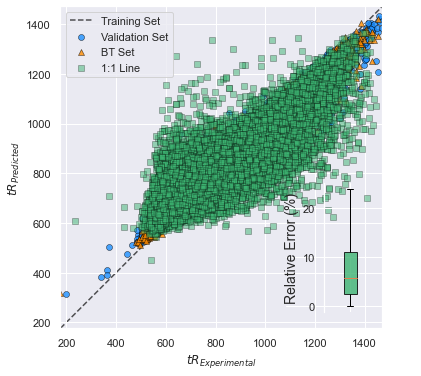

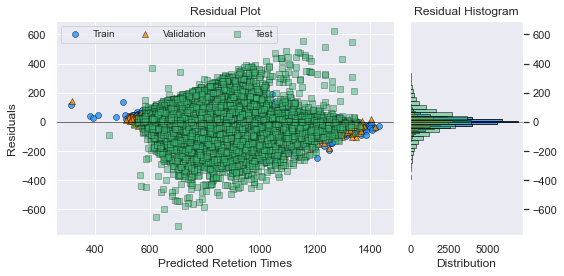

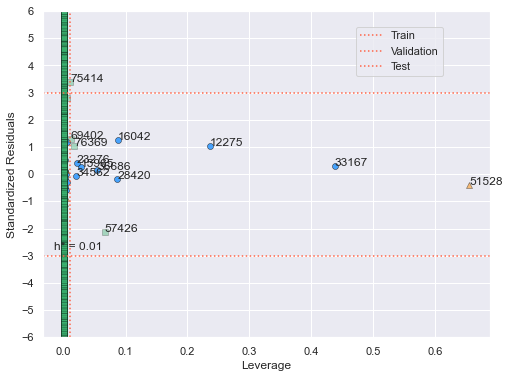

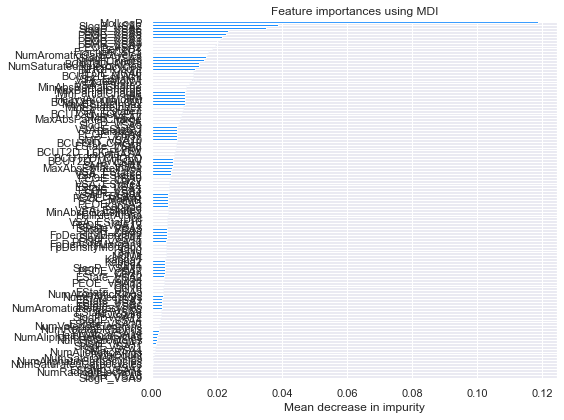

[CV 1/1; 6736/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=160
[CV 1/1; 6736/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=160;, score=-115.744 total time=   0.5s
[CV 1/1; 6755/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150
[CV 1/1; 6755/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=150;, score=-115.623 total time=   0.4s
[CV 1/1; 6771/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110
[CV 1/1; 6771/7200] END bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=110;, score=-115.631 total time=   0.3s
[CV 1/1; 6780/7200] START bootstrap=False, max_depth=26, max_features=sqrt, min_samples_leaf

[CV 1/1; 6530/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 1/1; 6530/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-136.898 total time=   1.2s
[CV 1/1; 6539/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190
[CV 1/1; 6539/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=190;, score=-136.908 total time=   2.4s
[CV 1/1; 6562/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20
[CV 1/1; 6562/7200] END bootstrap=False, max_depth=26, max_features=None, min_samples_leaf=3, min_samples_split=5, n_estimators=20;, score=-144.681 total time=   0.3s
[CV 1/1; 6566/7200] START bootstrap=False, max_depth=26, max_features=None, min_samples_leaf

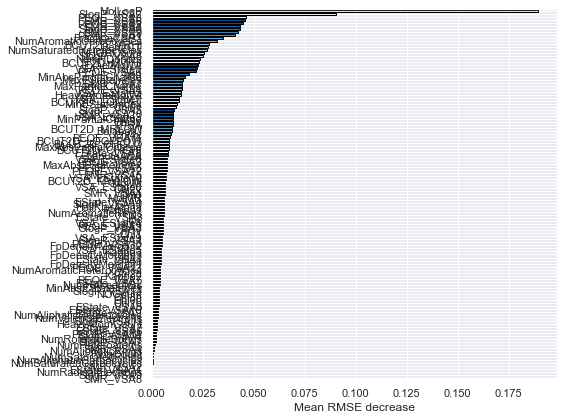

100%|===================| 54478/54530 [12:53<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 1355.905750, while the model output was 1432.480000. If this difference is acceptable you can set check_additivity=False to disable this check.

<Figure size 576x432 with 0 Axes>

In [9]:
# Analyze results
_rf_predictions_df, _rf_metrics_df = analyze_model(
    model=_rfs_optimal_model,
    cv=ps,
    title="Random Forests",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["rt"]).columns))
)

In [10]:
display(_rf_predictions_df.head())
display(_rf_metrics_df.head())

NameError: name '_rf_predictions_df' is not defined

##  Partial Least Squares
---

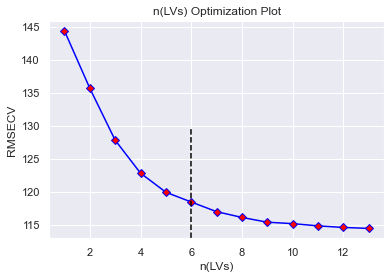

In [11]:
# Number of PLS components
_n_latent_variables: ndarray = np.array(range(1, 14, 1))

# Optimization of n(LVs)

_rmsecvs: List[float] = []

for _n_lvs in _n_latent_variables:

    _pls_model = make_pipeline(StandardScaler(), PLSRegression(n_components=_n_lvs))

    _cv = KFold(n_splits=10, shuffle=True, random_state=12345)

    _score = cross_val_score(
        _pls_model,
        deepcopy(_x_train),
        deepcopy(_y_train),
        scoring='neg_root_mean_squared_error',
        cv=_cv
    )

    _rmse = -_score.mean()
    
    _rmsecvs.append(_rmse)

_rmsecvs: ndarray = np.array(_rmsecvs)

Visualizer.latent_variable_plot(
    rmsecvs=_rmsecvs,
    latent_variables=_n_latent_variables,
    optimal_n_lvs=6,  # For reproducibility
    y_max=0.51  # For reproducibility
)

In [12]:
# Train PLS Model
_pls_optimal_model = make_pipeline(
    StandardScaler(),
    PLSRegression(n_components=6)
)

_pls_optimal_model.fit(
    deepcopy(_x_train),
    deepcopy(_y_train)
)

display(_pls_optimal_model)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('plsregression', PLSRegression(n_components=6))])

Results Analysis for : PLS


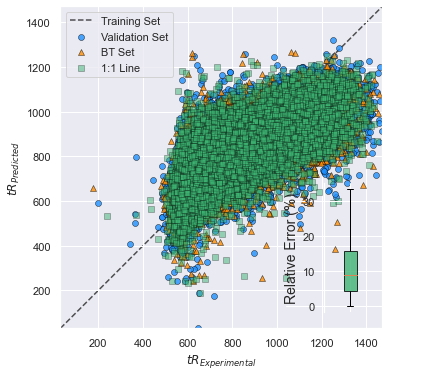

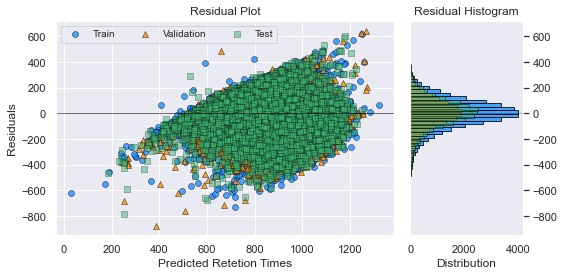

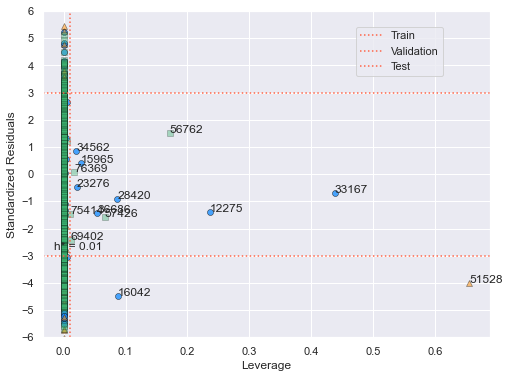

In [13]:
# Analyze results
_pls_predictions_df, _pls_metrics_df = analyze_model(
    model=_pls_optimal_model,
    cv=ps,
    title="PLS",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["rt"]).columns)),
    b_plot_feature_importances=False
)

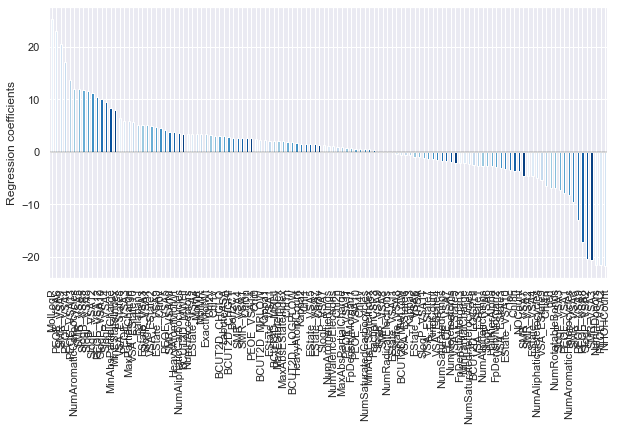

In [14]:
# PLS Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_pls_optimal_model.named_steps["plsregression"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["rt"])))
)

In [15]:
display(_pls_predictions_df.head())
display(_pls_metrics_df)

,0
r2_train,0.539583
rmse_train,118.286331
r2_validation,0.520446
rmse_validation,120.827966
r2_bt,0.531341


,y,y_hat,residuals,train_test,leverage,scaled_residuals
0,619.1,745.807641,126.707641,Train,0.000062,1.071194
1,1015.8,952.218774,-63.581226,Train,0.000047,-0.537520
2,654.6,752.366711,97.766711,Train,0.000144,0.826526
3,1346.1,925.486370,-420.613630,Train,0.000053,-3.555894
4,747.0,800.908714,53.908714,Train,0.000068,0.455748
...,...,...,...,...,...,...
77896,667.1,785.826575,118.726575,BT,0.000066,1.003722
77897,832.4,734.982122,-97.417878,BT,0.000132,-0.823577
77898,779.4,795.603671,16.203671,BT,0.000028,0.136987
77899,748.5,705.277107,-43.222893,BT,0.000115,-0.365409


## Gradient Boosting Regression
---

In [16]:
# GB parameter grid
_gb_param_grid = {
    'n_estimators': np.arange(10, 210, 10),
    'learning_rate':[.001, 0.01, .1],
    'max_features': [None, 'sqrt'],
    'max_depth': range(1, 6, 1),
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
}

In [17]:
# Instantiate GB model
_gb_model = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=12345),
    param_grid=_gb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=ps,
    n_jobs=6,
    verbose=1
)

In [18]:
# Fit model
_gb_model.fit(
    deepcopy(_x_train_all),  # Use all, because we extracted the validation indices previously for reproducibility
    deepcopy(_y_train_all.ravel())   # Use all, because we extracted the validation indices previously for reproducibility
)

Fitting 1 folds for each of 5400 candidates, totalling 5400 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=6,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(1, 6),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [19]:
# Optimal Results
print(f"Optimal hyper-parameters : {_gb_model.best_params_}")
print(f"Optimal RMSE : {-_gb_model.best_score_.round(3)}")

# Optimal Model
_gb_optimal_model: GradientBoostingRegressor = _gb_model.best_estimator_

display(_gb_optimal_model)

Optimal hyper-parameters : {'learning_rate': 0.1, 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Optimal RMSE : 103.584


GradientBoostingRegressor(max_depth=1, min_samples_leaf=3, n_estimators=200,
                          random_state=12345)

Results Analysis for : Gradient Boosting


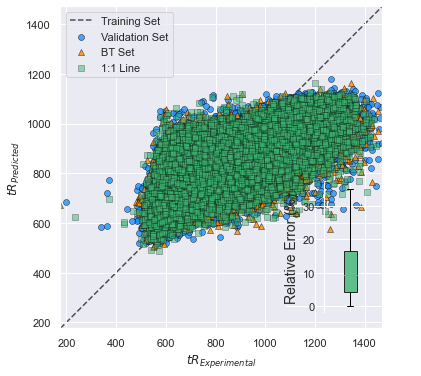

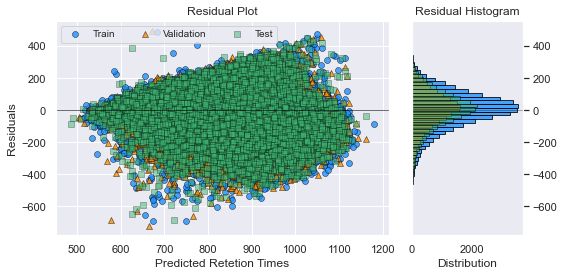

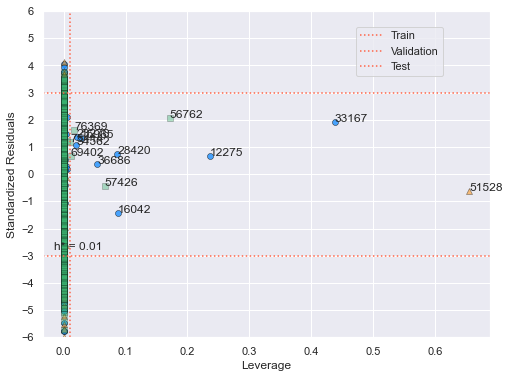

Average score after 1000 iteration: 187.7736803316708


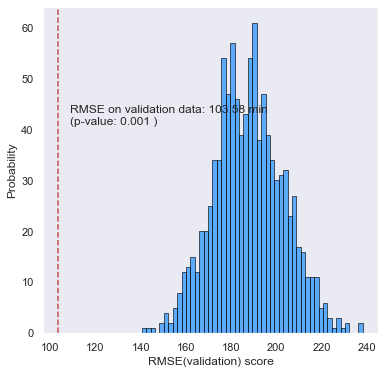

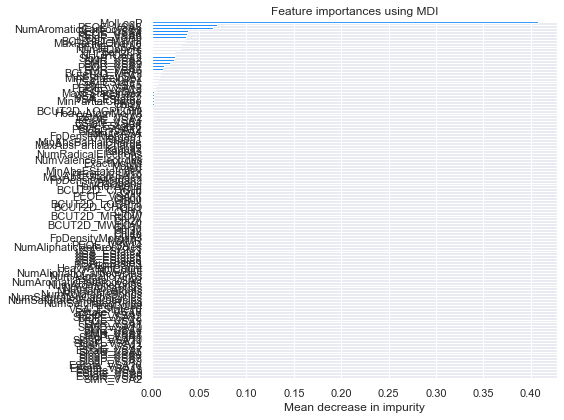

In [ ]:
# Analyze results
_gb_predictions_df, _gb_metrics_df = analyze_model(
    model=_gb_optimal_model,
    cv=ps,
    title="Gradient Boosting",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["rt"]).columns)),
    b_plot_y_randomization=True
)

In [ ]:
display(_gb_predictions_df.head())
display(_gb_metrics_df.head())

## Ridge Regression
---

In [ ]:
# Optimize the regularization parameter (alpha)
_ridge_model = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=[0.01, 0.1, 1, 10, 50, 100, 200],
        scoring= 'neg_root_mean_squared_error',
        cv=ps
    )
)

In [ ]:
_ridge_model.fit(
    X=deepcopy(_x_train_all),
    y=deepcopy(_y_train_all.ravel())
)

In [ ]:
# Display Optimal Results
print('Optimal alpha :',  _ridge_model.named_steps['ridgecv'].alpha_)
print('Optimal RMSE : ',  -_ridge_model.named_steps['ridgecv'].best_score_)

In [ ]:
# Analyze results
_ridge_predictions_df, _ridge_metrics_df = analyze_model(
    model=_ridge_model,
    cv=ps,
    title="Ridge Regression",
    x_train=deepcopy(_x_train),
    y_train=deepcopy(_y_train.ravel()),
    x_validation=deepcopy(_x_validation),
    y_validation=deepcopy(_y_validation.ravel()),
    x_bt=deepcopy(_x_bt),
    y_bt=deepcopy(_y_bt.ravel()),
    x_train_all=deepcopy(_x_train_all),
    y_train_all=deepcopy(_y_train_all.ravel()),
    x_all=deepcopy(_x),
    y_all=deepcopy(_y.ravel()),
    column_names=np.array(list(_data_df.drop(columns=["TR"]).columns)),
    b_plot_feature_importances=False
)

In [ ]:
# Ridge Coefficient Plot
Visualizer.coefficient_plot(
    coefficients=_ridge_model.named_steps["ridgecv"].coef_,
    column_names=np.array(list(_data_df.drop(columns=["rt"])))
)

In [ ]:
display(_ridge_predictions_df.head())
display(_ridge_metrics_df.head())